In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

import pmdarima as pm

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [ ]:
# Download and get the stock price data 

#!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

In [26]:
df = pd.read_csv('sp500sub.csv', index_col=0, parse_dates=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


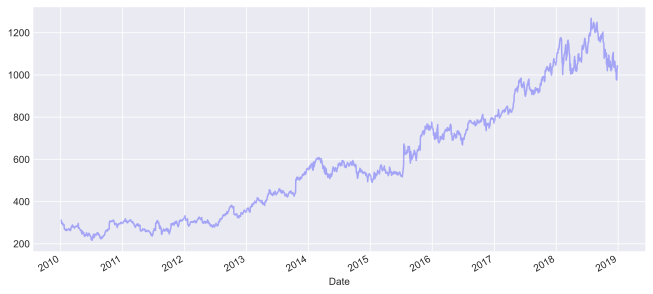

In [27]:
# get google 

goog = df[df['Name'] == 'GOOG']['Close']

fig, axes = plt.subplots(figsize = (11,5))

goog.plot(ax = axes, color = 'blue', alpha = 0.3)

axes.grid()


In [28]:
# train - test split 

Ntest = 30
train = goog[:-Ntest]
test = goog[-Ntest:]

In [29]:
model = pm.auto_arima(train,error_action='ignore', suppress_warnings=True, trace = True, maxiter = 10, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16270.771, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16270.383, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16269.726, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16269.492, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16271.123, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16268.077, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16267.935, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16268.277, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16266.968, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16264.983, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16266.925, Time=0.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16268.907, Time=0.62 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16265.470, Time=0.14 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 4.001 seconds


In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8127.491
Date:                Thu, 11 Apr 2024   AIC                          16264.983
Time:                        11:08:00   BIC                          16293.536
Sample:                             0   HQIC                         16275.409
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3104      0.198      1.571      0.116      -0.077       0.698
ar.L1          0.0378      0.012      3.152      0.002       0.014       0.061
ar.L2         -0.0410      0.013     -3.241      0.001      -0.066      -0.016
ar.L3          0.0488      0.012      4.031      0.000       0.025       0.073
sigma2        85.1623      1.033     82.421      0.000      83.137      87.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11790.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# get model parameters

model.get_params()

# notice that it is a dictionary

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (3, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [36]:
def plot_pred(model, data, train, test):

    params = model.get_params() 
    
    d = params['order'][1] # differencing order 

    #get train and test predictions 

    train_pred = model.predict_in_sample(start = d, end = -1)
    test_pred, conf_int = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, axes = plt.subplots(figsize = (11,5))

    # plot full data along with train predict and test predict

    axes.plot(data.index, data, color = 'blue', label  = 'Data', alpha = 0.5)
    axes.plot(train.index[d:], train_pred, color = 'green', alpha = 0.6, label = 'Fitted')
    axes.plot(test.index, test_pred, color = 'red', alpha = 0.5, label = 'Forecast')

    axes.fill_between(test.index, conf_int[:,0], conf_int[:,1], color = 'red', alpha = 0.1)

    axes.grid()
    axes.legend()

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


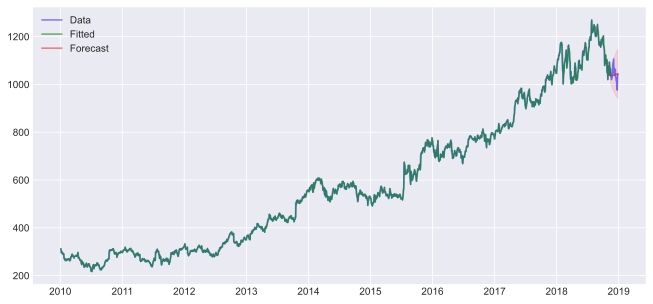

In [37]:
plot_pred(model, goog, train, test)

In [38]:
def plot_test_pred(model, test):

    #get test predictions 

    test_pred, conf_int = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, axes = plt.subplots(figsize = (11,5))

    # plot test data along with test predictions

    axes.plot(test.index, test, color = 'green', alpha = 0.6, label = 'Test Data')

    axes.plot(test.index, test_pred, color = 'red', alpha = 0.5, label = 'Forecast')
    axes.fill_between(test.index, conf_int[:,0], conf_int[:,1], color = 'red', alpha = 0.1)

    axes.grid()
    axes.legend()

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


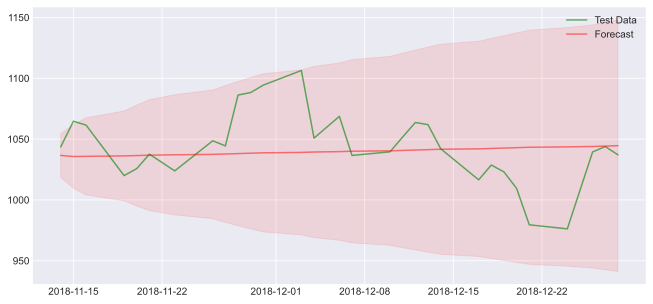

In [39]:
plot_test_pred(model, test)

In [48]:
np.ones(len(test))*train[-1]

array([1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883, 1036.05004883, 1036.05004883,
       1036.05004883, 1036.05004883])

It is a pretty bad forecast, however it seems to capture the average very well: true values are within the confidence intervals and the forecast in the middle of true vals.

In [59]:
# Does this model perform better than the naive forecast model ? 

print(f"RMSE of ARIMA(3,1,0): {mean_squared_error(model.predict(n_periods=Ntest),test, squared = False):.3f}")
print(f"RMSE of Naive forecast: {mean_squared_error(np.ones(len(test))*train[-1],test,squared = False):.3f}")

RMSE of ARIMA(3,1,0): 30.437
RMSE of Naive forecast: 30.030


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Even Naive forecast performs better!  

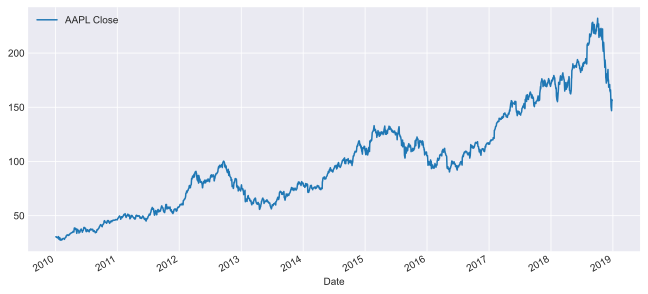

In [61]:
# get apple closing stock price 

aapl = df[df.Name == 'AAPL']['Close']

fig,axes = plt.subplots(figsize = (11,5))

aapl.plot(ax = axes, label = 'AAPL Close')

axes.grid()
axes.legend()

Notice that data has abnormal rises and drops. Now ask the question can SARIMA models capture such features in the data? They are designed to match simple patterns like trend, seasonality but by definition they are simple consistent patterns unlike a typical stock price fluctuations.  

In [62]:
# Lets see this once again
# train-test split 

train = aapl[:-Ntest]
test = aapl[-Ntest:]

In [63]:
model = pm.auto_arima(train, error_action = 'ignore', suppress_warnings=True, trace = True, maxiter= 10, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8570.296, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8575.329, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8574.709, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8574.392, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8577.622, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8571.650, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8571.332, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8572.500, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8572.527, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8574.574, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8570.852, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8570.880, Time=0.54 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8579.289, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8572.973, Time=0.23 sec

Best model:  ARIMA(2,1,2)(0,0,0)

In [64]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4279.148
Date:                Thu, 11 Apr 2024   AIC                           8570.296
Time:                        11:50:45   BIC                           8604.560
Sample:                             0   HQIC                          8582.808
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0803      0.042      1.896      0.058      -0.003       0.163
ar.L1          0.3755      0.165      2.279      0.023       0.053       0.699
ar.L2         -0.4239      0.176     -2.407      0.016      -0.769      -0.079
ma.L1         -0.3433      0.172     -2.002      0.045      -0.679      -0.007
ma.L2          0.3579      0.183      1.958      0.050      -0.000       0.716
sigma2         2.7182      0.039     69.453      0.000       2.642       2.795
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6223.04
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.23   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


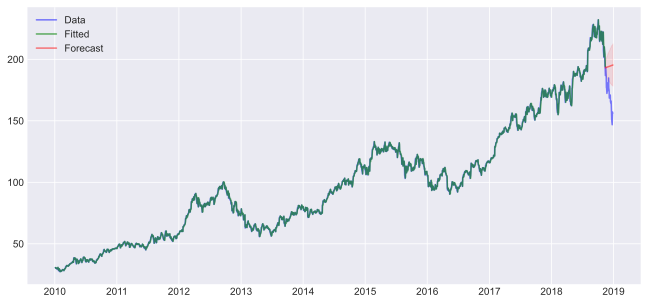

In [65]:
plot_pred(model, aapl, train, test)

Notice that the model is trying to carry the existing global trend! Remember they are relatively simple (and interpretable) models! 

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


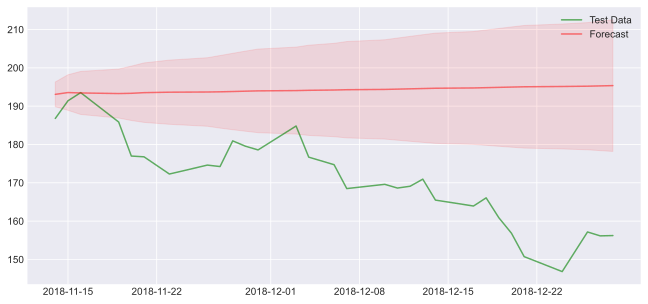

In [67]:
plot_test_pred(model, test)

In [68]:
# Does this model perform better than the naive forecast model ? 

print(f"RMSE of ARIMA(2,1,2): {mean_squared_error(model.predict(n_periods=Ntest),test, squared = False):.3f}")
print(f"RMSE of Naive forecast: {mean_squared_error(np.ones(len(test))*train[-1],test,squared = False):.3f}")

RMSE of ARIMA(2,1,2): 26.095
RMSE of Naive forecast: 24.027


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date'>

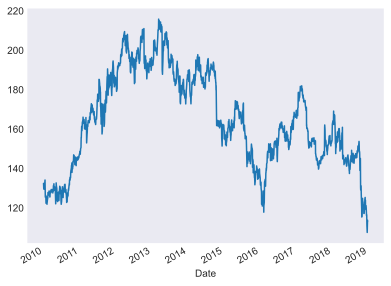

In [69]:
# Now get the IBM stock price 

ibm = df[df.Name == 'IBM']['Close']

ibm.plot()

In [70]:
# train-test split and train

train = ibm[:-Ntest]
test = ibm[-Ntest:]

model = pm.auto_arima(train, error_action='ignore', suppress_warnings=True, trace = True, maxiter = 10, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9442.954, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9436.082, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9437.603, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9437.589, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9434.097, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9439.637, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.347 seconds


In [71]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2233
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4716.049
Date:                Thu, 11 Apr 2024   AIC                           9434.097
Time:                        11:59:28   BIC                           9439.808
Sample:                             0   HQIC                          9436.183
                               - 2233                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.0067      0.055     72.559      0.000       3.898       4.115
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):              5352.76
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.77
Prob(H) (two-sided):                  0.03   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

No AR or MA component, the best model is just a random walk! IBM stock returns are completely unpredictable given lag values and lagged errors! 

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


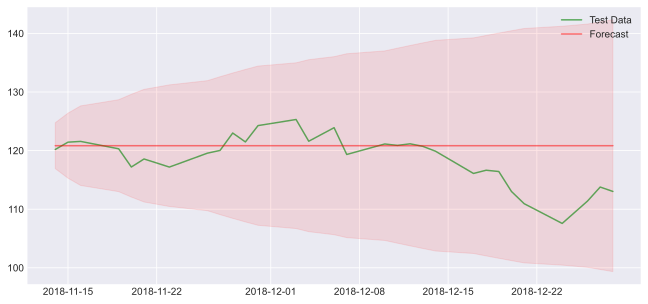

In [72]:
plot_test_pred(model,test)

In [73]:
# Does this model perform better than the naive forecast model ? 

print(f"RMSE of ARIMA(0,1,0): {mean_squared_error(model.predict(n_periods=Ntest),test, squared = False):.3f}")
print(f"RMSE of Naive forecast: {mean_squared_error(np.ones(len(test))*train[-1],test,squared = False):.3f}")

RMSE of ARIMA(0,1,0): 4.763
RMSE of Naive forecast: 4.763


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Notice that RMSE is the same as the naive forecast which is expected as they are equivalent. 